In [13]:
%matplotlib inline
%pdb on
%run _547

Automatic pdb calling has been turned ON


In [37]:
np.set_printoptions(precision=2)

# control system model
Consider the simplified quadrotor model
$$m\ddot{h} = u_1\sin\theta,$$
$$m\ddot{v} = -mg + u_1\cos\theta,$$
$$I\ddot{\theta} = u_2$$
where ($h$, $v$) denote the quadrotor (horizontal, vertical) position and $\theta$ denotes the quadrotor's rotation, ($m$, $I$) denote quadrotor (mass, inertia), $g$ is acceleration due to gravity, and ($u_1$, $u_2$) denote the net (thrust, torque) applied by the spinning rotors.

If we measure or observe positions ($h$, $v$), e.g. with GPS, then the control system model is
$$\frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ F((q,\dot{q}),u) \end{array}\right] = f((q,\dot{q}),u),\ y = h(q,\dot{q})$$
where $q = (h,v,\theta)\in\mathbb{R}^3$, $u = (u_1,u_2)\in\mathbb{R}^2$, $F : \mathbb{R}^3 \times \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is defined by 
$$F((q,\dot{q}),u) = \ddot{q} = \left[\begin{array}{c} \frac{u_1}{m}\sin\theta \\ -g + \frac{u_1}{m}\cos\theta \\ \frac{u_2}{I}\end{array}\right],$$ 
and $h : \mathbb{R}^3 \rightarrow \mathbb{R}^2$ is defined by 
$$h(q,\dot{q}) = (h,v).$$

    [1]: http://dx.doi.org/10.1109/ROBOT.2010.5509452

# Simulation
To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [72]:
g,m,I = 9.81,1.,1. # m/sec^2, kg, kg m^2

def f(t,x,u):
    q,dq = x[:3],x[3:] # positions, velocities
    h,v,theta = q # horiz., vert., rotation
    u1,u2 = u # thrust, torque
    return np.hstack([dq,(u1/m)*np.sin(theta),
                        -g + (u1/m)*np.cos(theta),
                        u2/I])

def h(t,x,u):
    q,dq = x[:3],x[3:] # positions, velocities
    h,v,theta = q # horiz., vert., rotation
    return np.array([h,v]) # horizontal, vertical position

Note that $\dot{q}_0 = 0$ (i.e. zero velocity) is an equilibrium with any position $q$ when input $u = (mg,0)$ (i.e. zero torque and thrust $mg$) is applied:

In [49]:
q0 = np.array([0.,1.,0.])
dq0 = np.array([0.,0.,0.])
x0 = np.hstack((q0,dq0))
u0 = np.array([m*g,0.])
print 'x0 =',x0,'\nf(x0) =',f(0.,x0,u0)

x0 = [ 0.  1.  0.  0.  0.  0.] 
f(x0) = [ 0.  0.  0.  0.  0.  0.]


Let's simulate the result of applying a sinusoidal thrust, and plot/animate the result:

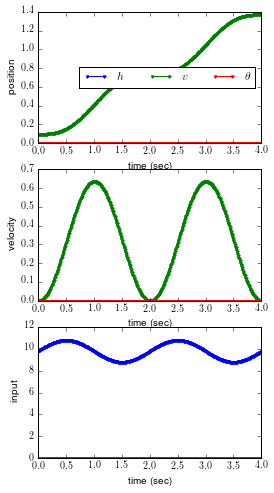

In [91]:
dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 2./freq # two periods
q = [0.,.1,0.] # start 10cm up off the ground
dq = [0.,0.,0.] # start with zero velocity
x = np.hstack((q,dq))

# input is a periodic function of time
ut = lambda t : np.array([m*g + np.sin(2*np.pi*t*freq),0.])
# lambda is a shorthand way to define a function
# -- equivalently:
def u(t):
    return np.array([m*g + np.sin(2*np.pi*t*freq),0.])

sim = forward_euler
t_,x_ = sim(f,t,x,dt=dt,ut=ut)
u_ = np.array([u(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. pos. and vel.) at time t_[j]

fig = plt.figure(figsize=(4,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position')
ax.legend([r'$h$',r'$v$',r'$\theta$'],ncol=3,loc='right')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

In [24]:
%run _anim

In [92]:
fig, ax = plt.subplots(figsize=(4,4)); ax.axis('equal'); ax.grid('on');

line, = ax.plot([], [], 'b', lw=2);

# initialization -- called once
def init():
    gndh,gndv = [-10.,10.,10.,-10.],[0.,0.,-5.,-.5]
    ax.fill(gndh,gndv,'gray')
    line.set_data([], [])
    ax.set_xlim(( -1., 1.))
    ax.set_ylim(( -.15, 2.))
    return (line,)

# animation -- called iteratively
def animate(t):
    j = (t_ >= t).nonzero()[0][0]
    h,v,th = x_[j,:3]
    w = .25
    x = np.array([-w/2.,w/2.,np.nan,0.,0.])
    y = np.array([0.,0.,np.nan,0.,+w/3.])
    z = (x + 1.j*y)*np.exp(1.j*th) + (h + 1.j*v)
    line.set_data(z.real, z.imag)
    return (line,)

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                        frames=np.arange(0.,t_[-1],.1), interval=20, blit=True)

To stabilize the quadrotor, we'll need to linearize the DE (i.e. take the derivative of the function $f$):

In [38]:
A = D(lambda x : f(0.,x,u(0)),x)
B = D(lambda u : f(0.,x,u),u(0))

print 'A =\n',A,'\n','B =\n',B

A =
[[ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]] 
B =
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  0.]
 [ 0.  1.]]


We can then design a stabilizing state feedback control law using a numerical routine implemented in the Control Systems module:

In [93]:
from control import lyap

W = lyap(-1.5*np.identity(6)-A,np.dot(B,B.T))
K = .5*np.dot(B.T,la.inv(W))

print "closed loop stable?",np.all(np.array(la.eigvals(A - np.dot(B,K))).real < 0)

ux = lambda x : np.dot(x - x0, -K.T) + u0

closed loop stable? True


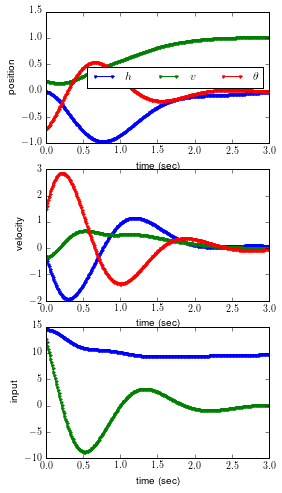

In [94]:
np.random.seed(50)

dt = 1e-2
t = 3. 
x = x0 + 3*(np.random.rand(6)-.5)

# input is now a function of state
ux = lambda x : np.dot(x - x0, -K.T) + u0

t_,x_ = sim(f,t,x,dt=dt,ux=ux)
u_ = np.array([ux(x) for x in x_])

fig = plt.figure(figsize=(4,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position')
ax.legend([r'$h$',r'$v$',r'$\theta$'],ncol=3,loc='right')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

In [95]:
fig, ax = plt.subplots(figsize=(4,4)); ax.axis('equal'); ax.grid('on');

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                        frames=np.arange(0.,t_[-1],.1), interval=20, blit=True)